#  Binary reponse models for panel data

### Econometrics B (ØkB)

Wooldridge (2010, Section 15.8)

Bertel Schjerning

Department of Economics, University of Copenhagen


## Plan for panel data models for binary response

We are interested in modeling
$$
P\left(y_{it}=1|x_{it},c_{i}\right) 
$$

That is, the response probability - holding $x_{it}$ and $c_i$ constant
### Roadmap
1. Binary response models without unobserved effects
2. Unobserved effects models under strict exogeneity
3. Dynamic unobserved effects models


### Panel data

$T$ observations of $N$ individuals
$$
y_{it},x_{it}\text{,  }i=1,...,N\text{, }t=1,..,T
$$
where $y_{it}=\left \{ 0,1\right \} $ is a binary random variable

As usual, we assume random sampling over $i$ (but not over $t)$

### Panel data: Married women's labor force participation
- Main empirical example thoughout 

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
df = pd.read_stata('lfp.dta')
Nobs=df['id'].count()
df['const']=np.ones((Nobs,1))
df.head(20)

id  period  lfp  black  educ  age  agesq  kids         hinc  per1  per2  \
0    1       1    0      0    12   47   2209     1  4933.741211     1     0   
1    1       2    1      0    12   47   2209     1  5582.057129     0     1   
2    1       3    0      0    12   47   2209     1  5723.005371     0     0   
3    1       4    0      0    12   47   2209     1  6678.280762     0     0   
4    1       5    1      0    12   47   2209     1  8496.932617     0     0   
5    2       1    0      0    12   26    676     2  2760.745117     1     0   
6    2       2    0      0    12   26    676     2  2900.658203     0     1   
7    2       3    0      0    12   26    676     2  2826.948975     0     0   
8    2       4    0      0    12   26    676     2  2868.138916     0     0   
9    2       5    0      0    12   26    676     2  3040.071045     0     0   
10   3       1    0      0    15   34   1156     3  1021.093506     1     0   
11   3       2    0      0    15   34   1156     3  1006.158752     0     1   
12   3       3    1      0    15   34   1156     3  3080.750244     0     0   
13   3       4    1      0    15   34   1156     3  1696.772827     0     0   
14   3       5    1      0    15   34   1156     3  1705.827026     0     0   
15   4       1    1      0    12   52   2704     0  1352.881348     1     0   
16   4       2    1      0    12   52   2704     0  1221.339111     0     1   
17   4       3    1      0    12   52   2704     0  1482.584717     0     0   
18   4       4    1      0    12   52   2704     0  1196.793701     0     0   
19   4       5    1      0    12   52   2704     0  1226.388306     0     0   

    per3  per4  per5     lhinc  const  
0      0     0     0  8.503853    1.0  
1      0     0     0  8.627313    1.0  
2      1     0     0  8.652249    1.0  
3      0     1     0  8.806616    1.0  
4      0     0     1  9.047461    1.0  
5      0     0     0  7.923256    1.0  
6      0     0     0  7.972693    1.0  
7      1     0     0  7.946953    1.0  
8      0     1     0  7.961419    1.0  
9      0     0     1  8.019636    1.0  
10     0     0     0  6.928629    1.0  
11     0     0     0  6.913895    1.0  
12     1     0     0  8.032928    1.0  
13     0     1     0  7.436483    1.0  
14     0     0     1  7.441805    1.0  
15     0     0     0  7.209992    1.0  
16     0     0     0  7.107703    1.0  
17     1     0     0  7.301542    1.0  
18     0     1     0  7.087401    1.0  
19     0     0     1  7.111829    1.0

### Some descriptive statistics

In [2]:
print('Summary stats - pooled')
#display(df.describe())
print('Within group standard deviation:'); print(df.groupby('id').std().mean().round(5)) 
print('Between group standard deviation:'); display(df.groupby('id').mean().std().round(5)) 

Summary stats - pooled
Within group standard deviation:
period      1.58114
lfp         0.09187
black       0.00000
educ        0.00000
age         0.00000
agesq       0.00000
kids        0.09164
hinc      635.34459
per1        0.44721
per2        0.44721
per3        0.44721
per4        0.44721
per5        0.44721
lhinc       0.25790
const       0.00000
dtype: float64
Between group standard deviation:


period       0.00000
lfp          0.42465
black        0.25053
educ         2.66740
age          9.97516
agesq      819.86868
kids         1.18688
hinc      1654.38831
per1         0.00000
per2         0.00000
per3         0.00000
per4         0.00000
per5         0.00000
lhinc        0.58182
const        0.00000
dtype: float64

### Some more Python Libraries and variables used in various specifications


In [3]:
from numpy import linalg as la
from tabulate import tabulate
import linearpaneldata as lpd   # simple routines to do linear FE and Pooled OLS regressions
from indexmodels import *       # objective functions etc. for estimation of panel data binary response models
import mestim as M              # routines for M-estimation given general sample objective functions

# names of variables use thoughout
y_it=['lfp']                           # binary response variable: Labor force participation
x_it=['kids', 'lhinc']                 # time varying explanatory varibles  
x_t=['per2', 'per3', 'per4', 'per5']   # time dummies (leave one out)
x_i=['educ','black', 'age', 'agesq']   # time constant explanatory varibles (not used in FE regressions)
groupvar = 'id'                        # individual indicator

### Object of interest
We are interested in modeling
$$
P\left(y_{it}=1|x_{it},c_{i}\right) 
$$

That is, the response probability - holding $x_{it}$ and $c_i$ constant

### A starting point: Linear Probability Model
Linear unobserved effects model:

\begin{eqnarray*}
P\left( y_{it}=1|x_{it},c_{i}\right) &=&E\left[ y_{it}=1|x_{it},c_{i}\right] \\
&=&x_{it}\beta +c_{i}
\end{eqnarray*}

Problems are the usual ones:
- $P\left( y_{it}=1|x_{it},c_{i}\right)$ not bounded between zero and one
- $V\left( y_{it}|x_{it},c_{i}\right) $ depend on $x$ and $c_{i}$ (Heteroscedasticity)
- ***and*** unnatural restrictions on $c_{i}$, $-x_{it}\beta \leq c_{i}\leq 1-x_{it}\beta $

Advantages
- Easy to remove $c_{i}$ (within transformation, FD, etc)


### Parameter Estimates - Linear Fixed Effects Regression

In [4]:
# Column 1 in table 15.3 Wooldridge (p. 623)
lpm_fe=lpd.estim(df, y_it, xvar=x_it+x_t , groupvar='id', method='fe', cov_type='robust')
lpm_pols=lpd.estim(df, y_it, xvar=x_it+x_t+x_i, groupvar='id', method='pols', cov_type='robust')


Specification: Linear Fixed Effects Regression
Dep. var. : ['lfp'] 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
kids           -0.0389      0.0092     -4.2435
lhinc          -0.0089      0.0046     -1.9469
per2           -0.0043      0.0034     -1.2586
per3           -0.0109      0.0042     -2.6034
per4           -0.0123      0.0045     -2.7389
per5           -0.0177      0.0049     -3.6429
# of groups:       5663
# of observations: 28315 


Specification: Pooled OLS Panel Regression
Dep. var. : ['lfp'] 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
kids           -0.0679      0.0050    -13.5249
lhinc          -0.0646      0.0067     -9.6017
per2           -0.0024      0.0037     -0.6367
per3           -0.0091      0.0045     -2.0349
per4           -0.0131      0.0047     -2.7502
per5           -0.0169      0.0051     -3.3323
educ            0.0267      0.0021     12.6236
black         

### Index models without unobserved effects
Assume no unobserved effect
$$
P\left( y_{it}=1|x_{it}\right) =G\left( x_{it}\beta \right) ,t=1,2,...,T%
$$

We have not nearly assumed enough to obtain joint distribution of $
y_{i}=\{y_{i1},..,y_{iT}\}$ given $x_{i}=\{x_{i1},..,x_{iT}\}$

- Example:$\ y_{i}|x_{i}$ could be serially correlated
- **We need more assumptions to use CMLE!**

Could we use another estimator?

### Estimator: Partial MLE

Readings: Partial MLE (Wooldridge 13.8)

We can obtain a $\sqrt{N}$ consistent estimator of $\beta $ by maximizing *partial* likelihood

$$
\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T}\left \{ \underset{\ell _{it}\left(
y_{i}|x_{i};\beta \right) }{\underbrace{y_{it}\ln \left( G\left( x_{it}\beta
\right) \right) +\left( 1-y_{it}\right) \ln \left( 1-G\left( x_{it}\beta
\right) \right) }}\right \} 
$$

Note that $\hat{\beta}_{PML}$ *is clearly an M-estimator*
\begin{eqnarray*}
\hat{\beta}_{PML} &=&\arg \min_{\beta \in \Theta }\frac{1}{N}
\sum_{i=1}^{N}q\left( y_{i}|x_{i};\beta \right) \text{, where} \\
q\left( y_{i}|x_{i};\beta \right) &=&-\sum_{t=1}^{T}\ell _{it}\left(
y_{i}|x_{i};\beta \right) 
\end{eqnarray*}

In [5]:
def Q_pooled(y, x, T, beta, model='probit', out='Q'):
    ''' Pooled linear index model for panel data. e.g pooled probit or logit
        y:      Nobs x 1 np.array of binary response data
        x:      Nobs x k np.array of explanatory variables
        T:      n x 1  np.array of containing number of time observations for each group 
        model:  'probit' or 'logit'
        out:    controls what is returned - can be 'predict','Q', 'dQ', 's_i', or 'H'
    '''

    beta=np.array(beta).reshape(-1,1)             # parameters
    n=T.shape[0];                                 # number of groups
    xb=x @ beta                                   # Linear index 
    Gx=G(xb, model)                               # Response probability at x
    gx=g(xb, model)                               # Density at xb
    Gx=np.minimum(np.maximum(Gx,1e-15),1-1e-15)   # Truncating Gx
    if out=='predict':  return xb, Gx, gx         # Return predicted values

    ll_it = np.log(Gx)*y + np.log(1-Gx)*(1-y)     # Nobsx1 vector of log-likelihood contributions for group i at time t
    q_i= - sumby(ll_it, T)                        # nx1 vector of (negative) log-likelihood contributions 
    if out=='Q': return np.mean(q_i);             # Return Q: sample objective function to be minimized - negative of log-likelihood

    # 1st order derivatives
    s_it=gx*x*(y-Gx)/( Gx* (1-Gx))                # NobsxK array of derivatives of ll_it
    s_i = sumby(s_it, T)                          # nxK array of derivatives of ll_i (transposed scores staked over i)
    if out=='s_i': return s_i                     # Return s_i: nxK array with scores
    if out=='dQ':  return -np.mean(s_i, axis=0);  # Return dQ: array of size K derivative of sample objective function

    # 2nd order derivatives
    H=(gx*x).T @(gx*x/(Gx* (1-Gx)))/n             # Analytical Hessian averaged over all groups i
    # H=s_it.T@ s_it/n                            # Alternative: use product of gradient as Hessian approximation
    if out=='H':    return H; 

### Parameter Estimates - Pooled Probit
Column 2 in table 15.3 Wooldridge (p. 623)

In [6]:
def pooled(df, yvar, xvar, groupvar, model='probit', cov_type='sandwich', deriv=1): 
    print('Pooled', model)
    Nobs, k, n, T, y, x = panel_setup(df, yvar, xvar, groupvar)
    Qfun     = lambda beta, out:  Q_pooled(y, x, T, beta, model, out)
    res=M.estimation(Qfun, theta0=np.zeros((k,1)), deriv=deriv, cov_type=cov_type, parnames=xvar)
    xb, Gx, gx = Qfun(res.theta_hat, out='predict')
    APE=np.mean(gx)*res.theta_hat
    res.update(dict(zip(['yvar', 'xvar', 'Nobs','k', 'n', 'T', 'APE'], [yvar, xvar, Nobs, k, n, T, APE])))
    print_output(res)
    return res
res_pp=pooled(df, y_it, xvar=x_it+x_t+x_i + ['const'] , groupvar='id', model='probit')

Pooled probit
Dep. var. : ['lfp'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
kids           -0.19891     0.01445   -13.76457    -0.00000    -0.06602
lhinc          -0.21107     0.02159    -9.77522     0.00000    -0.07005
per2           -0.01242     0.01034    -1.20178     0.00000    -0.00412
per3           -0.03252     0.01168    -2.78368    -0.00000    -0.01079
per4           -0.04610     0.01257    -3.66801    -0.00000    -0.01530
per5           -0.05778     0.01242    -4.65278     0.00000    -0.01918
educ            0.07969     0.00618    12.88540    -0.00000     0.02645
black           0.22094     0.05933     3.72402    -0.00000     0.07333
age             0.14492     0.01097    13.20588     0.00000     0.04810
agesq          -0.00199     0.00014   -14.46445     0.00000    -0.00066
const          -1.06445     0.22302    -4.77280    -0.00000    -0.35328

# of groups:      : 5663
# 

### Properties of Partial MLE

**Since $\hat{\beta}_{PML}$ is an M-estimator**
- $\hat{\beta}_{PML}$ is consistent (if identified) - by theorem 12.2 
- $\hat{\beta}_{PML}$ is asymptotic normal - by theorem 12.3


**But objective function is not based a the conditional density of $y_{i}$ given $x_{i;}$**
- Need to do inference using the methods of ch. 12 to take account for potential serial correlation
- Variance-covariance matrix on the form, $A^{-1}BA^{-1}$, $A\neq B$
- Wald Statistics (12.63) and score statistics (12.68)

In [7]:
def avar(s_i, Ainv, cov_type ='sandwich'):
    n, K=s_i.shape
    B=s_i.T@ s_i/n 
    if cov_type=='Binv':        return la.inv(B)/n
    if cov_type=='Ainv':        return Ainv/n;         
    if cov_type=='sandwich':    return Ainv @ B @ Ainv/n

se={'parnames':res_pp.xvar, 'theta_hat':res_pp.theta_hat}
for cov_type in ['Ainv', 'Binv', 'sandwich']:
    cov = avar(res_pp.s_i, res_pp.hess_inv, cov_type)
    se[cov_type]=  np.sqrt(np.diag(cov))
print(tabulate(se, headers="keys",floatfmt="10.5f"))

parnames      theta_hat        Ainv        Binv    sandwich
----------  -----------  ----------  ----------  ----------
kids           -0.19891     0.00725     0.00367     0.01445
lhinc          -0.21107     0.01226     0.00702     0.02159
per2           -0.01242     0.02390     0.06298     0.01034
per3           -0.03252     0.02312     0.05302     0.01168
per4           -0.04610     0.02311     0.05503     0.01257
per5           -0.05778     0.02256     0.04868     0.01242
educ            0.07969     0.00311     0.00157     0.00618
black           0.22094     0.03163     0.01698     0.05933
age             0.14492     0.00582     0.00312     0.01097
agesq          -0.00199     0.00007     0.00004     0.00014
const          -1.06445     0.12645     0.07970     0.22302


### What did we assume?

1. No unobserved effects
2. Linear Index structure 

$$
P\left( y_{it}=1|x_{it}\right) =G\left( x_{it}\beta \right) 
$$

3. A functional form for $G\left( {}\right)$. 
	- For example: $G\left( {}\right) =\Phi \left( {}\right) $ (Pooled Probit)

'
- We will relax 1) later in this lecture

- Semi/Non-parametric approaches can be used to relax 2) and 3)

### What did we NOT assume?

1. Dynamic Completeness

$$
P\left( y_{it}=1|x_{it},y_{it-1},x_{it-1},y_{it-2},....\right) =P\left(
y_{it}=1|x_{it}\right) 
$$

2. Strict exogeneity (conditional on a unobserved effect)

$$
P\left( y_{it}=1|x_{i},c_{i}\right) =P\left( y_{it}=1|x_{it},c_{i}\right) 
$$

### Under dynamic completeness

Dynamically complete models

$$
P\left( y_{it}=1|x_{it},y_{it-1},x_{it-1},y_{it-2},....\right) =P\left(
y_{it}=1|x_{it}\right) 
$$

- We are not assuming independence ($x_{it}$ can contain lagged dependent variables)
- Easier to justify when $x_{it}$ contains lagged values of $y_{it}$ and $x_{it}$
- Does not imply independence: 
	- $x_{it}$ can contain lagged dependent variables
	- But scores are independent across $t$
- Inference is easier
    - We can just treat the sample as one big cross-section of size $NT$

    - Why: $A_{0}=B_{0}$ for PML when scores are serially uncorrelated (see 13.8)

### Test for dynamic completeness

1. Estimate artificial model and generate residuals 
$$
\hat{u}_{it}=y_{it}-G\left( x_{it}\hat{\beta}\right) 
$$

2. Estimate model where residuals is included 
$$
P\left( y_{it}=1|x_{it},\hat{u}_{it-1}\right) =G\left( x_{it}\beta +\gamma _{1}\hat{u}_{it-1}\right)
$$

3. Test $H_{0}:\gamma _{1}=0$. 

If $H_{0}$ is rejected so is dynamic completeness.

- This works because $u_{it}$ must uncorrelated with any function of 
$\left\{x_{it},y_{it-1},x_{it-1},y_{it-2}...\right \} $ including $u_{it-1}$

# Unobserved Effects Models

### Unobserved Effects Models under Strict Exogeneity

**Strict exogeneity (and index restriction) implies**

\begin{eqnarray*}
P\left( y_{it}=1|x_{i},c_{i}\right) &=&P\left( y_{it}=1|x_{it},c_{i}\right) \\
&=&G\left( x_{it}\beta +c_{i}\right) 
\end{eqnarray*}

**Strict Exogeneity**
- $x_{it}$ cannot include lagged dependent variables or explanatory variables with feedback from current and past values of $y_{it}$

- Reason is completelely anologous to our previous discussion for the linear model

**Problem: $c_{i}$ is unobserved**

- We can not condition on $c_{i}$ (it is unobserved)
- It cannot be differenced away - due to the nonlinearity of $G()$

### How to deal with unobserved effect?

Some possibilities: 

1. **Estimate $c_{i}$** (treat as a parameter)
	- We can never consistently estimate $c_{i}$ for a given $T$
	- Incidental Parameters Problem}: $\hat{\beta}$ is not $\sqrt{N}$-consistent for fixed $T$ (unlike in the linear case)
	- Need long panel to estimate $c_{i}$ (at least 7-10 observations for each individual)

2. **Random Effects:** Assume distribution of $c_{i}|x_{i}$ and integrate out $c_{i}$.
	- How do we come up with a distribution 
	- Example below

### More possibilities

3. **Fixed Effects:** Eliminate $c_{i}$ by transformation
	- We can not difference $c_{i}$ out - due to non-linearity
	- Not easy to find transformation (vary from model to model)
	- Example below

4. **Pooled analysis**
	- if we are willing to assume particular random effects structure and interest is in $APE$

### Random Effects: Assumptions

Random Effects Linear Index Models
1. Strict exogeneity (and index structure)
$$
P\left( y_{it}=1|x_{i},c_{i}\right) =G\left( x_{it}\beta +c_{i}\right) 
$$
2. Independence of $y_{i1},..,y_{iT}$ conditional on $\left(x_{i},c_{i}\right)$
implies that : $f\left( y_{1},..,y_{T}|x_{i},c;\beta \right)=\prod_{t=1}^{T}f\left( y_{t}|x_{it},c,\beta \right) $

3. Normality of $c_{i}|x_{i}$
$$
c_{i}|x_{i}\sim N\left( 0,\sigma _{c}^{2}\right) 
$$
Implies: $c_{i}$ and $x_{i}$ are independent and that $c_{i}$ has a normal distribution

Alternative to 3): Discrete support for $c_{i}$ and independence between $x_{i}$ and $c_{i}$

Under these assumptions we can estimate model with CMLE



### Random Effects: Discrete support 
Joint distribution of $y_{i}|x_{i}$
$$
f\left( y_{1},..,y_{T}|x_{i};\theta \right) =\sum_{j}\pi
^{j}\prod_{t=1}^{T}f\left( y_{t}|x_{it},c^{j},\beta \right) 
$$
where 
$$
f(y_{t}|x_{it},c,\beta) =  y_{t}G(x_{it}\beta +c) + (1-y_{t}) [ 1-G(x_{it}\beta +c)]
$$
and 
$$
\sum_{j}\pi ^{j}=1\text{  and }\sum_{j}\pi ^{j}c^{j}=0
$$

NOTE: $\pi ^{j}$ and $c^{j}$ are parameters to be estimated


### Random Effects: Discrete Support
**Examble with 2 support points: $c^{l}$ and $c^{h}$**
Joint distribution of $y_{i}|x_{i}$
\begin{eqnarray*}
f\left( y_{1},..,y_{T}|x_{i};\theta \right) &=&\pi^{l}\prod_{t=1}^{T}f\left( y_{t}|x_{it},c^{l},\beta \right) \\
&&+\left( 1-\pi ^{l}\right) \prod_{t=1}^{T}f\left( y_{t}|x_{it},-\pi^{l}/\left( 1-\pi ^{l}\right) c^{l},\beta \right) 
\end{eqnarray*}

Two additional parameters to be estimated
- Probability of being a low type, $\pi$
- Support point for low type, $c^{l}$



### Random Effects: Normally Distributed $c_i$

Joint distribution of $y_{i}|x_{i}$

$$
f\left( y_{1},..,y_{T}|x_{i};\theta \right) =\int_{-.\infty }^{\infty
}\prod_{t=1}^{T}f\left( y_{t}|x_{it},c,\beta \right) \frac{1}{\sigma _{c}}%
\phi \left( c/\sigma _{c}\right) dc
$$

where 
$$
f\left( y_{t}|x_{it},c,\beta \right) = y_{t}G\left( x_{it}\beta +c\right) +
\left( 1-y_{t}\right) \left[ 1-G\left( x_{it}\beta +c\right) \right]
$$

**How to evaluate integral?**

1. Gaussian Quadrature
(for example Gauss-Hermite quadrature for integrals on the form $\int_{-.\infty}^{\infty }h\left( z\right) \exp \left( -z^{2}\right) dz$)
2. Simulation (The integrals equivalent to take expectations over random variable)

## RECAP: Gaussian quadrature

General formula

$$
\int_a^b f(x)w(x) dx = \sum_{i=1}^n \omega_i f(x_i) + \text{approximation error}
$$

- $w(x)$ non-negative weighting function
- $ x_i \in [a,b] $ quadrature nodes  
- $ \omega_i $ quadrature weights
- Nodes and weights are chosen so that there is no approximation error if $f(x)$ belongs to the family of $2n-1$ degree polynomials
- Choice of method differ by weighting function $w(x)$ and domain $[a, b]$

## Gaussian quadrature
$$
\int_a^b f(x)w(x) dx = \sum_{i=1}^n \omega_i f(x_i) + \text{approximation error}
$$

- Gauss-Legendre Quadrature ($w(x)=1$, domain $[a, b]$)
- Gauss-Chebyshev Quadrature ($w(x)=(1-x^2)^{(-1/2)} $, domain  $[a, b]$)
- Gauss-Hermite Quadrature ($w(x)=\exp(−𝑥^2)$, domain  $[-\infty, \infty]$)
- Gauss-Laguerre Quadrature ($w(x)=\exp(−𝑥)$, domain  $[a, \infty]$)



### Gauss-Legendre Quadrature

- Domain $ [-1,1]$ .. or   $[a,b]$
- Weighting $ 1 $  


$$
\int_{-1}^1 f(x) dx = \sum_{i=1}^{n} \omega_i f(x_i) + \frac{2^{2n+1}(n!)^4}{(2n+1)!(2n)!}\frac{f^{(2n)}(\xi)}{(2n)!}
$$





- Nodes and weights come from Legendre polynomials, values tabulated  
- Good for computing expectation of random variables with finite support.
- Can also be used for computing expectation if transforming using inverse CDF (has domain [0,1]]
- The method of choice when no obvious weighting function can be used

### Change of variable for Gauss-Legendre
A linear change of variable is nessesary to apply Gauss-Legendre quadrature to general intervals $[a, b]$ rather than $[−1, 1]$ 

This change of interval from $[a, b]$ to $[−1, 1]$ can be done in the following way:

$$
{\displaystyle \int _{a}^{b}f(x)\,dx={\frac {b-a}{2}}\int _{-1}^{1}
f\left({\frac {(x+1)(b-a)}{2} +a }\right)\,dx .}
$$

Applying n point Gaussian quadrature ${\displaystyle (x ,w)}$ rule then results in the following approximation:

$$
{\displaystyle \int _{a}^{b}f(x)\,dx\approx {\frac {b-a}{2}}\sum _{i=1}^{n}w_{i}
f\left({\frac {(x_i+1)(b-a)}{2} +a }\right)\,dx .}
%f\left({\frac {b-a}{2}}x _{i}+{\frac {a+b}{2}}\right).}
$$

### Approximation of joint distribution of $y_{i}|x_{i}$ using Gauss-Legendre
We can reformulate the integral by making the simple change of variable 
$$c_i=\sigma _{c}\Phi^{-1}(q_i)$$ 
where $q_i$ is now uniformly rather than normally distributed

We get
\begin{eqnarray*}
f\left( y_{1},..,y_{T}|x_{i};\theta \right) 
&=&\int_{-.\infty }^{\infty}\prod_{t=1}^{T}f\left( y_{t}|x_{it},c,\beta \right) \frac{1}{\sigma _{c}}\phi \left( c/\sigma _{c}\right) dc \\
&=&\int_{0}^{1}\prod_{t=1}^{T}f\left( y_{t}|x_{it},\sigma _{c}\Phi^{-1}(q),\beta \right) dq
\end{eqnarray*}
This integral is easily approximated by Gauss-Legendre quadrature 
$$
\int_{0}^{1}\prod_{t=1}^{T}f\left( y_{t}|x_{it},\sigma _{c}\Phi^{-1}(q),\beta \right) dq \approx
\sum_{j=1}^{m}w_j\prod_{t=1}^{T}f\left( y_{t}|x_{it},\sigma _{c}\Phi^{-1}(q_j),\beta \right)=
\sum_{j=1}^{m}w_j f(q_j)
$$
where $w_j$ and $q_j$ are Gauss-Legendre weights and nodes for adjusted to the interval $[0,1]$  

In [8]:
def Q_RE(y, x, T, theta, model='probit', out='Q', R=20, rng=random.default_rng(seed=11)):
    ''' Pooled linear index model for panel data. e.g pooled probit or logit
        y:      Nobs x 1 np.array of binary response data
        x:      Nobs x k np.array of explanatory variables
        T:      n x 1  np.array of containing number of time observations for each group 
        model:  'probit' or 'logit'
        out:    controls what is returned - can be 'predict','Q', 'dQ', 's_i', or 'H'
    '''
    Nobs, k= x.shape
    n=T.shape[0];                                 # number of groups

    sigma_a=theta[-1]                             # heterogeneity parameter
    beta=np.array(theta[:-1]).reshape(-1,1)       # slope parameters
    
    xb=x @ beta                                   # Linear index 
    gx=g(xb, model)                               # Density at xb
    Gx=G(xb).reshape(-1,1)
    if out=='predict':  return xb, Gx, gx         # Return predicted values

    # compute alpha for used sample objective function at Legendre quadrature nodes
    q,w=quad_xw(R, a=0, b=1)
    q=q.reshape(1,R)
    w=w.reshape(1,R)
    eta=norm.ppf(q);
    alpha=sigma_a*eta

    G_itq=G(xb + alpha, model)                          # Reponse probability at x for each quadrature point (Nobs x R)
    G_itq=np.minimum(np.maximum(G_itq,1e-15),1-1e-15)   # Truncating G
    F_itq = G_itq*y + (1-G_itq)*(1-y)                   # Nobsx1 vector of log-likelihood contributions for group i at time t
    F_iq  = prodby(F_itq,T)                             # product over time, n by R
    Fi = np.sum(F_iq*w, axis=1).reshape(-1,1)           # sum over quad/sims, n by 1 (likelihood contribution for unit i)
    q_i= - np.log(Fi)                                   # nx1 vector of (negative) log-likelihood contributions 
    if out=='Q': return np.mean(q_i);                   # Return Q: sample objective function to be minimized - negative of log-likelihood

    # 1st order derivatives
    g_itq=g(xb + alpha, model)
    s_itq=g_itq*(y-G_itq)/(G_itq*(1-G_itq)) # Nobs x R
    n_p=theta.shape[0]
    s_i=np.empty((n, n_p))                          # nxK+1 array of derivatives of ll_i (transposed scores staked over i)
    for ip in range(n_p-1):
        dw_iq=sumby(s_itq*x[:,ip].reshape(-1,1), T);  # n x R 
        s_i[:,ip]=np.sum(w*F_iq*dw_iq/Fi.reshape(-1,1),axis =1)  # sum over quad/sim points
    dw_iq=sumby(s_itq*eta, T);  # n x R 
    s_i[:,-1]=np.sum(w*F_iq*dw_iq/Fi,axis =1)       
    if out=='s_i': return s_i                       # Return s_i: nxK array with scores
    if out=='dQ':  return -np.mean(s_i, axis=0);    # Return dQ: array of size K derivative of sample objective function

    # 2nd order derivatives
    H=s_i.T@ s_i/n                                  # Alternative: use product of gradient as Hessian approximation
    if out=='H':    return H; 

### Gauss-Hermite Quadrature

- Domain $ [-\infty,\infty] $  
- Weighting $ \exp(-x^2) $  


$$
\int_{-\infty}^{\infty} f(x) \exp(-x^2)dx = \sum_{i=1}^{n} \omega_if(x_i) + \frac{n!\sqrt{\pi}}{2^n}\frac{f^{(2n)}(\xi)}{(2n)!}
$$

- Nodes and weights come from Hermite polynomials, values tabulated  
- Good for computing expectation with Normal distribution 
$$
E[f(y)]
=(2\pi\sigma^2)^{-1/2}\int_{-\infty}^{\infty} f(y)e^{-(y-\mu)^2/(2\sigma^2)}dy
$$

since normal density is proportional to $\exp(-x^2)$ after  appropriate change of variable $x=(y-\mu)/(\sqrt{2}\sigma)$ so that $y=\sqrt{2}\sigma x+ \mu$ and $dy=\sqrt{2}\sigma dx$
$$
E[f(y)]
=\pi^{-1/2}\int_{-\infty}^{\infty} f(\sqrt{2}\sigma x+ \mu)e^{-x^2}dx
$$



### Approximation of joint distribution of $y_{i}|x_{i}$ using Gauss-Hermite
We have an integral on this form
\begin{eqnarray*}
&&\int_{-.\infty }^{\infty }\prod_{t=1}^{T}f\left( y_{t}|x_{it},c,\beta
\right) \frac{1}{\sigma _{c}}\phi \left( c/\sigma _{c}\right) dc \\
&=&\pi^{-1/2}\int_{-.\infty }^{\infty }\prod_{t=1}^{T}f\left( y_{t}|x_{it},z\sqrt{2\sigma _{c}^{2}},\beta \right) \exp \left(-z^{2}\right)dz\\
&=&\int_{-.\infty }^{\infty }h\left( z\right) \exp \left( -z^{2}\right) dz \cong \sum_{j}w_{j}h\left( z_{j}\right)\\
&=&\pi^{-1/2}\sum_{j=1}^{m}w_j\prod_{t=1}^{T}f\left( y_{t}|x_{it},z_j\sqrt{2\sigma _{c}^{2}},\beta \right)\\
\end{eqnarray*}
where 
$$ h(z) = \pi^{-1/2}\prod_{t=1}^{T}f\left( y_{t}|x_{it},z\sqrt{2\sigma _{c}^{2}},\beta \right) $$
and
- $w_{j}$ are Hermite quadrature weights
- $z_{j}$ are Hermite quadrature nodes
- The more nodes - The higher the precision

### Random Effects: Maximum Simulated Likelihood Estimation

Simulation Likelihood contribution individual $i$
1. Take $R$ independent draws from the standard normal label them $\eta^{r},$ $r=1,..,R$
2. Compute $c_{i}^{r}=\sigma _{c}\eta ^{r}$
3. Compute $\prod_{t=1}^{T}f\left( y_{it}|x_{it},c^{r},\beta \right) $ for each $r$
3. Average the results and take logs 
$$
\hat{\ell}_{i}\left( \theta \right)=\ln \frac{1}{R}\sum_{i=1}^{R}\prod_{t=1}^{T}f\left(
y_{it}|x_{it},c^{r},\beta \right) 
$$

**Estimation:**
Maximize sample average of log of simulated likelihood w.r.t. $\theta=\left\{ \beta ,\sigma _{c}^{2}\right \}$
$$
\hat{\theta}_{MSL}=\arg \max_{\theta =\left \{ \beta ,\sigma _{c}^{2}\right\} }\frac{1}{N}\sum_{i=1}^{N}\ln\frac{1}{R}\sum_{i=1}^{R}\prod_{t=1}^{T}f\left( y_{it}|x_{it},c^{r},\beta \right)
$$




### Remarks on Simulated Based Estimation

Properties of MSL
1. If R is fixed, MSL is inconsistent.
2. If R rises slower than$\sqrt{N}$, MSL is consistent but not asymptotically normal.
3. If R rises faster than $\sqrt{N}$, MSL is consistent, asymptotically normal and efficient, and equivalent to MLE.

### How to relax assumptions on unobserved effect within random effects framework?

We can relax assumptions by re-specifying model
- Serial correlation: Requires evaluation of $T$ dimensional integrals (use simulation methods)
- Chamberlain approach: Specified correlation with $x_{i}$

### Fixed Effects Logit

**The trick:**
- Model the joint distribution of $y_{i}$ conditional on $x_{i}$, $c_{i}$ *and* $n_{i}=\sum_{t}y_{it}$
- In the logit model, it turns out that this does not depend on $c_{i}.$
- For $T=2$ we have
\begin{eqnarray*}
P\left( y_{i2}=1|x_{i},c_{i},n_{i}=1\right) &=&\Lambda \left( \left(x_{i2}-x_{i1}\right) \beta \right) \\
P\left( y_{i1}=1|x_{i},c_{i},n_{i}=1\right) &=&1-\Lambda \left( \left(
x_{i2}-x_{i1}\right) \beta \right) 
\end{eqnarray*}

$$
l_{i}\left( \beta \right) =\left(n_{i}=1\right) \left \{ 
\begin{array}{c} 
w_{i}\Lambda \left( \left( x_{i2}-x_{i1}\right) \beta \right) + \\ 
\left( 1-w_{i}\right) \left( 1-\Lambda \left( \left( x_{i2}-x_{i1}\right) \beta \right) \right)
\end{array}
\right \} 
$$
- NOTE: We cannot use this trick eliminate $c_{i}$ in the probit model



### Fixed Effects Logit: Identification
Identification:
- Conditional distribution of $y_{it}$ is not informative about $\beta $, when $n_{i}=0$ or $n_{i}=T$ 
(since $n_{i}=0$ and $n_{i}=2$ perfectly predict $y_{it}$)
- We therefore need time-series variation in $y_{it}$ to identify $\beta $

**Identified objects**
- We can identify $\beta$ (up to scale) and obtain the effect on the log-odd ratio:
$$
\ln \left[ \frac{\left( \Lambda \left( x_{t}^{\prime }\beta \right) \right) 
}{\left( 1-\Lambda \left( x_{t}^{\prime }\beta \right) \right) }\right] = x_{t}^{\prime }\beta +c%
$$

**Unidentified objects**
- Partial effects cannot be estimated unless we assume *value* of $c$
- $APE$ can't be estimated - since we do not assume *distribution* of $c$

# Simulation exercise
Model 
\begin{eqnarray*}
y_{it}&=&1(z_{it} \delta + \rho y_{it-1} + c_i +e_{it}>0)\\
c_i   &=& \phi_0 + \phi_{y0} y_{i0} + a_i\\
a_i|x_i, y_0 &\sim&  N(0, \sigma_a^2)\\
e_{it}|x_i,a_i, y_0 &\sim& N(0, 1)
\end{eqnarray*}


In [9]:
from indexmodels import *
df_sim=simulate(n=1000, nT=10, model='probit', rho=0, delta=1, phi_0=0, phi_y0=0, sigma_a=1)
print(df_sim)

       group  period    y         z   y0  const  l1.y
1        0.0     1.0  1.0  0.678178  1.0    1.0   1.0
2        0.0     2.0  1.0 -0.585529  1.0    1.0   1.0
3        0.0     3.0  0.0 -0.908673  1.0    1.0   1.0
4        0.0     4.0  0.0 -1.991838  1.0    1.0   0.0
5        0.0     5.0  0.0  0.971623  1.0    1.0   0.0
...      ...     ...  ...       ...  ...    ...   ...
10995  999.0     6.0  0.0 -0.754210  0.0    1.0   0.0
10996  999.0     7.0  0.0 -0.985524  0.0    1.0   0.0
10997  999.0     8.0  1.0  1.078294  0.0    1.0   0.0
10998  999.0     9.0  1.0  0.750458  0.0    1.0   1.0
10999  999.0    10.0  1.0  2.052021  0.0    1.0   1.0

[10000 rows x 7 columns]


### Experiments - static models
1. No heterogeneity 
    - does LPM give a good approximation of APE
    - does pooled probit estimate true parameters
    
1. Neglect heterogeneity - Pooled probit or LPM
   - does pooled probit estimate true parameters?
   - does pooled OLS and probit still estimate APE

1. Can RE-Probit estimate account for heterogeneity and uncover true parameters


In [10]:
delta=1; sigma_a=2
df_sim=simulate(n=1000, nT=10, model='probit', delta=delta, sigma_a=sigma_a, phi_y0=0)
lpm_ols=lpd.estim(df_sim, 'y', xvar=['z', 'const'], groupvar='group', method='pols', cov_type='robust')
lpm_fe=lpd.estim(df_sim, 'y',  xvar=['z'], groupvar='group', method='fe', cov_type='robust')
res_pp=pooled(df_sim, 'y', xvar =['z', 'const'] , groupvar='group', model='probit', cov_type='sandwich')


Specification: Pooled OLS Panel Regression
Dep. var. : y 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
z               0.1665      0.0052     32.2766
const           0.4958      0.0112     44.3676
# of groups:       1000
# of observations: 10000 


Specification: Linear Fixed Effects Regression
Dep. var. : y 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
z               0.1664      0.0046     36.1068
# of groups:       1000
# of observations: 10000 

Pooled probit
Dep. var. : y 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
z               0.45785     0.01700    26.92896     0.00000     0.16634
const          -0.01123     0.03076    -0.36507     0.00000    -0.00408

# of groups:      : 1000
# of observations : 10000
# log-likelihood. : -6355.062021375215 

Iteration info: 4 iterations, 5 ev

## Neglegted heterogeneity in pooled probit
- Recall that we only estimate parameters up to a scale, $\beta/\sigma$,  where $\sigma^2$ is the variance on the error component in the latent variable formulation. 
- To obtain identification for probit we normalize $\sigma^2$ to one
- We have two errors $v_{it}=a_i + e_{it}$ whose variance is $1+\sigma_a^2$
- So what we have estimated is $\beta/\sigma=\beta/\sqrt{1+\sigma_a^2}$
- Pooled probit consistently estimates $P(y_{it}|x_{it})=\Phi({x\beta/\sigma})$ and average partial effect $E_c(\beta/\sigma \phi(x\beta+c))=E(\beta/\sigma \phi(x\beta/\sigma))$
- Is neglected heterogeneity a problem in static models?


In [11]:
sigma_a=0; delta=1;
df_sim=simulate(n=1000, nT=10, model='probit', delta=delta, sigma_a=sigma_a, phi_y0=0)
res_pp=pooled(df_sim, 'y', xvar =['z', 'const'] , groupvar='group', model='probit', cov_type='sandwich')
print('true delta                     :' , delta)
print('delta_hat - pooled probit      :' , res_pp.theta_hat[0,0])
print('delta/(np.sqrt(1+sigma_a**2))  :' , delta/np.sqrt(1+sigma_a**2))
print('(np.sqrt(1+sigma_a**2))  :' , np.sqrt(1+sigma_a**2))

Pooled probit
Dep. var. : y 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
z               1.01709     0.01877    54.19892    -0.00004     0.28385
const          -0.00023     0.01434    -0.01575    -0.00001    -0.00006

# of groups:      : 1000
# of observations : 10000
# log-likelihood. : -4951.4290013457685 

Iteration info: 4 iterations, 5 evaluations of objective, and 5 evaluations of gradients
Elapsed time: 0.0820 seconds

true delta                     : 1
delta_hat - pooled probit      : 1.0170920062980178
delta/(np.sqrt(1+sigma_a**2))  : 1.0
(np.sqrt(1+sigma_a**2))  : 1.0


## Can RE-Probit estimate account for heterogeneity and uncover true parameters?

In [12]:
df_sim=simulate(n=10000, nT=10, model='probit', delta=1, sigma_a=2, phi_y0=0)
res_rep=pooled(df_sim, 'y', xvar =['z', 'const'] , groupvar='group', model='probit', cov_type='Binv')
res_rep=rand_effect(df_sim, 'y', xvar =['z', 'const'] , groupvar='group', model='probit', cov_type='Binv')

Pooled probit
Dep. var. : y 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
z               0.44872     0.00366   122.49781    -0.00002     0.16344
const          -0.00995     0.00172    -5.77644    -0.00006    -0.00362

# of groups:      : 10000
# of observations : 100000
# log-likelihood. : -63715.64871934356 

Iteration info: 3 iterations, 4 evaluations of objective, and 4 evaluations of gradients
Elapsed time: 0.6281 seconds

Random effects probit
Dep. var. : y 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
z               1.00612     0.00887   113.46412    -0.00000     0.16403
const          -0.02313     0.02145    -1.07826    -0.00000    -0.00377
sigma_a         1.99600     0.02249    88.74109    -0.00000     0.32540

# of groups:      : 10000
# of observations : 100000
# log-likelihood

# Dynamic models

### Dynamic Unobserved Effects Models

**Dynamic model**

$$
P\left( y_{it}=1|y_{it-1},y_{it-2},....,y_{i0},z_{i},c_{i}\right) =G\left(
z_{it}\delta +\rho y_{it-1}+c_{i}\right) 
$$


- Particular interest is in coefficient on lagged dependent variable (state dependence)
- $z_{it}$ is strictly exogenous

**Spurious state dependence**
- Note that even if $\rho=0$ we have 
$$
P\left( y_{it}=1|y_{it-1},z_{i}\right) \ne P\left( y_{it}=1|z_{i}\right)
$$
- This is due to the presence of $c_i$ 
- **Important to appropriately control for $c_{i}$**





### How to deal with unobserved effect
Joint density for $y_t$ for periods $1$ to $T$, conditional on $z_t$, $c$ and $y_0$
\begin{eqnarray*}
f\left(y_{1},..,y_{T}|z, c, y_0;\beta \right) 
&=& \prod_{t=1}^{T}f\left( y_{t}|y_{t-1},\dots y_0, z_{t},c; \beta \right) \\
&=& \prod_{t=1}^{T}
G\left(z_{t}\delta +\rho y_{t-1}+c\right)^{y_{t}} 
\left[ 1-G\left(z_{t}\delta +\rho y_{t-1}+c   \right) \right]^{1-y_{t}}
\end{eqnarray*}

1. **Estimate $c_{i}$ ?**
	- **NO:** Incidental parameters problem is even more severe in dynamic models (Heckman 1981)
    
2. **Dynamic Random Effects Model**
	- Integrate out $c_{i}$
	- Initial condition problem: $c_{i}$ is likely to be correlated with initial conditions $y_{i0}$
    - Otherwise, if $\rho>0$ $c_i$ is correlated with $y_t$ for all other periods than $t=0$ (VERY unrealistic)

### How to deal initial conditions problem
**Several approaches**
1. Treat $y_{i0}$ as random, i.e. assume independence between $y_{i0}$ and $c_{i}$ (*very* strong assumption)
2. Wooldridge/Chamberlain approach: 
	- Assume distribution for $c|y_{0};z$ 
	- Leading example: $N\left( \psi +\xi _{0}y_{i0}+z_{i}\xi ,\sigma_{a}\right) $
	- Approximation of distribution for $y_{i0}|z_{i},c_{i}$ (Heckman, 1981)
3. Semiparametric approaches 
	- in a model with fixed effects (Honoré and Kyriazidou, 2000)

### A simple solution to initial conditions in the probit model
**Chamberlain/Wooldridge approach:**

Assume 
$$
c|y_{0};z\sim N\left( \psi +\xi _{0}y_{i0}+z_{i}\xi ,\sigma _{a}\right) 
$$

or equivalently

\begin{eqnarray*}
c_{i} &=&\psi +\xi _{0}y_{i0}+z_{i}\xi +a_{i} \\
a_{i} &\sim &N\left( 0,\sigma _{a}\right) 
\end{eqnarray*}

For the probit model, $G\left( {}\right) =\Phi \left( {}\right) $ we have latent variable form
\begin{eqnarray*}
y_{it} &=&1\left[ z_{it}\delta +\rho y_{it-1}+c_{i}+e_{it}\right] \\
&=&1\left[ z_{it}\delta +\rho y_{it-1}+\psi +\xi _{0}y_{i0}+z_{i}\xi+a_{i}+e_{it}\right] 
\end{eqnarray*}
where $e_{it}\sim N\left( 0,1\right)$

### A simple solution to initial conditions in the probit model

**Chamberlain/Wooldridge approach:**

Recall the estimating equation

$$
y_{it}=1\left[ z_{it}\delta +\rho y_{it-1}+\psi +\xi _{0}y_{i0}+z_{i}\xi+a_{i}+e_{it}\right] 
$$

- This equation can be estimated by a standard random effects probit
- Simply add $y_{i0}$ and $z_{i}$ to the conditioning set to take account of
	1. initial conditions problem
	2. **specified** correlation between $c_{i}$ and $z_{i}$

# Simulation exercise
Model 
\begin{eqnarray*}
y_{it}&=&1(z_{it} \delta + \rho y_{it-1} + c_i +e_{it}>0)\\
c_i   &=& \phi_0 + \phi_{y0} y_{i0} + \phi_{z} \bar{z}_{i} + a_i\\
a_i &\sim&  iidN(0, \sigma_a^2)\\
e_{it} &\sim& iidN(0, 1)
\end{eqnarray*}
- I apologize for yet another almost unforgivable ZIG-ZAG  and abuse of notation. Notion on this slide attempts to match code and experiments below ... not the notation in presentation above that attempts to follow Wooldridge. 


### Experiments - dynamic models   
1. Neglecting heterogeneity and initial conditions
   - does pooled OLS and probit consistently estimate APE of lagged y (state dependence)?
   - what about other parameters?
1. Accounting for heterogeneity and initial conditions 
    - is LPM-FE valid for dynamic models?
    - can RE probit estimate APE of lagged y (state dependence)?
    - what if x is correlated with $c_i$?


In [13]:
df_sim=simulate(n=5000, nT=10, model='probit', delta=1, rho=1, sigma_a=1, phi_y0=1)
df_sim
xit=['z', 'l1.y']; xi=['const', 'y0']
lpm_ols=lpd.estim(df_sim, 'y', xvar=xit + xi, groupvar='group', method='pols', cov_type='robust')
res_pp=pooled(df_sim, 'y', xvar =xit + xi, groupvar='group', model='probit')
lpm_fe=lpd.estim(df_sim, 'y',  xvar=xit, groupvar='group', method='fe', cov_type='robust')
res_rep=rand_effect(df_sim, 'y', xvar =xit + xi , groupvar='group',model='probit', cov_type='sandwich', deriv=2)


Specification: Pooled OLS Panel Regression
Dep. var. : y 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
z               0.1557      0.0020     78.3180
l1.y            0.4113      0.0053     77.0443
const           0.3883      0.0053     73.7272
y0              0.1027      0.0047     22.0079
# of groups:       5000
# of observations: 50000 

Pooled probit
Dep. var. : y 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
z               0.72965     0.00919    79.36865    -0.00000     0.15543
l1.y            1.47187     0.01831    80.39558     0.00000     0.31355
const          -0.39079     0.01697   -23.02547     0.00000    -0.08325
y0              0.48295     0.02210    21.84866     0.00000     0.10288

# of groups:      : 5000
# of observations : 50000
# log-likelihood. : -19110.342881005367 

Iteration info: 6 iterations, 7 evaluations of obje

### Some remarks on experiments - dynamic models   
1. Pooled OLS and probit 
    - heavily over estimates APE on $y_{it-1}$ when $c_i$ is present (spurious state dependence)
    - but provides good approximation on APE of $z_{it}$
2. LPM-FE is not appropriate for dynamic models
    - but still approximates APE of $z_{it}$ well when $c_i$ is uncorrelated with $y_0$
    - underestimates state dependence when there is no unobserved heterogeneity
    - we also see massive problems with spurious state dependence when $c_i$ and $y_0$ are correlated 
1. Accounting for heterogeneity and initial conditions 
    - RE probit estimates both parameters, partial effects and APEs  consistently, but is biased if $z_i$ is correlated with $c_i$. 
    - Solution within RE framework: allow for specified correlation between $c_i$ and $z_i$
    - To allow for arbitrary correlation, we need to use dynamic fixed effects approach (Honoré and Kyriazidou, 2000), but we would the loose identification of APEs. 

### Empirical Application: Married women's labor force participation 

### Let's first create some variables 

In [14]:
from indexmodels import *
df = pd.read_stata('lfp.dta')
Nobs=df['id'].count()
df['const']=np.ones((Nobs,1))
df[30:40]
xbar_i=x_it.copy()
i=0
for j in x_it:
    xbar_i[i]=j + '_bar'
    df[j + '_bar']= df[j].groupby(df[groupvar]).transform('mean')
    for t in range(5): 
        df[j + str(t+1)]=df[j].groupby(df[groupvar]).transform(lambda x: x.to_numpy()[t])
        
    i+=1
df = addlag(df, 'lfp', t0=1)
df['lfp1']=df['lfp'].groupby(df['id']).transform(lambda x: x.to_numpy()[0] )


In [15]:
df[0:5].T

0            1            2            3            4
id            1.000000     1.000000     1.000000     1.000000     1.000000
period        1.000000     2.000000     3.000000     4.000000     5.000000
lfp           0.000000     1.000000     0.000000     0.000000     1.000000
black         0.000000     0.000000     0.000000     0.000000     0.000000
educ         12.000000    12.000000    12.000000    12.000000    12.000000
age          47.000000    47.000000    47.000000    47.000000    47.000000
agesq      2209.000000  2209.000000  2209.000000  2209.000000  2209.000000
kids          1.000000     1.000000     1.000000     1.000000     1.000000
hinc       4933.741211  5582.057129  5723.005371  6678.280762  8496.932617
per1          1.000000     0.000000     0.000000     0.000000     0.000000
per2          0.000000     1.000000     0.000000     0.000000     0.000000
per3          0.000000     0.000000     1.000000     0.000000     0.000000
per4          0.000000     0.000000     0.000000     1.000000     0.000000
per5          0.000000     0.000000     0.000000     0.000000     1.000000
lhinc         8.503853     8.627313     8.652249     8.806616     9.047461
const         1.000000     1.000000     1.000000     1.000000     1.000000
kids_bar      1.000000     1.000000     1.000000     1.000000     1.000000
kids1         1.000000     1.000000     1.000000     1.000000     1.000000
kids2         1.000000     1.000000     1.000000     1.000000     1.000000
kids3         1.000000     1.000000     1.000000     1.000000     1.000000
kids4         1.000000     1.000000     1.000000     1.000000     1.000000
kids5         1.000000     1.000000     1.000000     1.000000     1.000000
lhinc_bar     8.727498     8.727498     8.727498     8.727498     8.727498
lhinc1        8.503853     8.503853     8.503853     8.503853     8.503853
lhinc2        8.627313     8.627313     8.627313     8.627313     8.627313
lhinc3        8.652249     8.652249     8.652249     8.652249     8.652249
lhinc4        8.806616     8.806616     8.806616     8.806616     8.806616
lhinc5        9.047461     9.047461     9.047461     9.047461     9.047461
l1.lfp             NaN     0.000000     1.000000     0.000000     0.000000
lfp1          0.000000     0.000000     0.000000     0.000000     0.000000

### Estimation of static models 
(Col 1-4 Table 15.3 )

In [16]:
# Linear FE - Column 1 of Table 15.3 
lpm_fe=lpd.estim(df, y_it, xvar=x_it+x_t , groupvar='id', method='fe', cov_type='robust')


Specification: Linear Fixed Effects Regression
Dep. var. : ['lfp'] 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
kids           -0.0389      0.0092     -4.2435
lhinc          -0.0089      0.0046     -1.9469
per2           -0.0043      0.0034     -1.2586
per3           -0.0109      0.0042     -2.6034
per4           -0.0123      0.0045     -2.7389
per5           -0.0177      0.0049     -3.6429
# of groups:       5663
# of observations: 28315 



In [17]:
# Pooled probit - Column 2 of Table 15.3 
res_pp=pooled(df, y_it, xvar=x_it + x_i + x_t + ['const'] , groupvar='id', model='probit')

Pooled probit
Dep. var. : ['lfp'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
kids           -0.19891     0.01562   -12.73582     0.00000    -0.06602
lhinc          -0.21107     0.02525    -8.35840     0.00000    -0.07005
educ            0.07969     0.00662    12.04501    -0.00000     0.02645
black           0.22094     0.06615     3.33985     0.00000     0.07333
age             0.14491     0.01225    11.82677    -0.00000     0.04810
agesq          -0.00199     0.00015   -13.01384     0.00000    -0.00066
per2           -0.01242     0.01046    -1.18792     0.00000    -0.00412
per3           -0.03252     0.01274    -2.55182     0.00000    -0.01079
per4           -0.04610     0.01364    -3.38036     0.00000    -0.01530
per5           -0.05778     0.01464    -3.94689     0.00000    -0.01918
const          -1.06443     0.26312    -4.04534     0.00000    -0.35328

# of groups:      : 5663
# 

In [18]:
# Pooled probit with xbar_i - Column 3 of Table 15.3 
res_pp_CRE=pooled(df, y_it, xvar=x_it + xbar_i + x_i + x_t + ['const'] , groupvar='id', model='probit')

Pooled probit
Dep. var. : ['lfp'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
kids           -0.11736     0.02764    -4.24520     0.00000    -0.03885
lhinc          -0.02881     0.01480    -1.94653     0.00000    -0.00954
kids_bar       -0.08571     0.03192    -2.68473    -0.00000    -0.02837
lhinc_bar      -0.25020     0.03615    -6.92076     0.00000    -0.08282
educ            0.08413     0.00679    12.38859     0.00000     0.02785
black           0.20304     0.06665     3.04651    -0.00000     0.06721
age             0.15163     0.01254    12.08955     0.00000     0.05019
agesq          -0.00207     0.00016   -13.21091    -0.00000    -0.00068
per2           -0.01357     0.01037    -1.30860    -0.00000    -0.00449
per3           -0.03320     0.01272    -2.61080     0.00000    -0.01099
per4           -0.03903     0.01364    -2.86165     0.00000    -0.01292
per5           -0.05524     

In [19]:
# Correlated RE probit with xbar_i - Column 4 of Table 15.3 
# NOTE: Looks like Wooldrige have used buggy version of STATA, sigma_a is heavly under estimated. 
#      New version of STATA gives results more siliar to what we find below
sigma_a0=1
theta0=res_pp_CRE.theta_hat*np.sqrt(1+sigma_a0**2)
theta0=np.append(theta0,sigma_a0).reshape(-1,1)
xvar=x_it + xbar_i + x_i + x_t + ['const']
from indexmodels import *
res_rep=rand_effect(df, y_it,xvar, groupvar='id', theta0=theta0)

Random effects probit
Dep. var. : ['lfp'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
kids           -0.39545     0.06131    -6.45042    -0.00000    -0.03156
lhinc          -0.09946     0.04172    -2.38396    -0.00000    -0.00794
kids_bar       -0.43154     0.08692    -4.96458    -0.00000    -0.03444
lhinc_bar      -1.05936     0.12807    -8.27153    -0.00000    -0.08453
educ            0.35047     0.02519    13.91497    -0.00000     0.02797
black           0.81020     0.24304     3.33365    -0.00000     0.06465
age             0.63511     0.04943    12.84747    -0.00000     0.05068
agesq          -0.00862     0.00061   -14.04589    -0.00000    -0.00069
per2           -0.04522     0.04500    -1.00488     0.00000    -0.00361
per3           -0.12454     0.04496    -2.76982    -0.00000    -0.00994
per4           -0.13537     0.04553    -2.97313     0.00000    -0.01080
per5           -0.19

### Estimation of dynamic models 
(Selected results from Example 15.6)


In [20]:
# Pooled probit with controls for correlation with x_it - spurious state dependence
res_dyn_pp=pooled(df.dropna(), y_it, xvar=['l1.lfp'] + x_it + x_i +x_t[1:] + ['const'], groupvar='id', model='probit')

Pooled probit
Dep. var. : ['lfp'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
l1.lfp          2.87568     0.03305    87.01890    -0.00000     0.35783
kids           -0.06081     0.01084    -5.60930    -0.00002    -0.00757
lhinc          -0.11430     0.02066    -5.53112    -0.00002    -0.01422
educ            0.02920     0.00465     6.27961     0.00004     0.00363
black           0.07940     0.04982     1.59362     0.00001     0.00988
age             0.08445     0.00919     9.18935    -0.00000     0.01051
agesq          -0.00110     0.00011    -9.80960     0.00006    -0.00014
per3           -0.03400     0.04101    -0.82899     0.00001    -0.00423
per4            0.00234     0.03776     0.06186     0.00000     0.00029
per5           -0.03037     0.03474    -0.87429    -0.00000    -0.00378
const          -2.17208     0.20884   -10.40090    -0.00001    -0.27028

# of groups:      : 5663
# 

In [21]:
# Pooled probit with controls for correlation with x_it
z_i=['kids2', 'kids3', 'kids4', 'kids5', 'lhinc2', 'lhinc3', 'lhinc4', 'lhinc5', 'lfp1']
res_dyn_pp_controls=pooled(df.dropna(), y_it, xvar=['l1.lfp'] + x_it + x_i +x_t[1:] + ['const']+ z_i , groupvar='id', model='probit')

Pooled probit
Dep. var. : ['lfp'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
l1.lfp          2.28904     0.04188    54.65112    -0.00000     0.27311
kids            0.00058     0.07089     0.00816    -0.00001     0.00007
lhinc          -0.05910     0.04758    -1.24216    -0.00001    -0.00705
educ            0.02682     0.00568     4.72317    -0.00001     0.00320
black           0.07364     0.06008     1.22578    -0.00000     0.00879
age             0.07510     0.01151     6.52768    -0.00002     0.00896
agesq          -0.00099     0.00014    -7.09088    -0.00007    -0.00012
per3           -0.05126     0.04219    -1.21491    -0.00000    -0.00612
per4           -0.02323     0.03858    -0.60228    -0.00000    -0.00277
per5           -0.05499     0.03602    -1.52676     0.00000    -0.00656
const          -2.05843     0.26236    -7.84573    -0.00000    -0.24559
kids2           0.16388     

In [22]:
# Random effects probit with controls for correlation with x_it
sigma_a0=1
theta0=res_dyn_pp_controls.theta_hat*np.sqrt(1+sigma_a0**2)
theta0=np.append(theta0,sigma_a0).reshape(-1,1)
res_dynrep=rand_effect(df.dropna(), y_it, xvar=['l1.lfp'] +x_it + x_i +x_t[1:] + ['const']+ z_i  , groupvar='id', model='probit', theta0=theta0)

Random effects probit
Dep. var. : ['lfp'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
l1.lfp          1.54208     0.06478    23.80439     0.00000     0.15540
kids           -0.14553     0.07131    -2.04079     0.00000    -0.01467
lhinc          -0.07483     0.04547    -1.64587     0.00000    -0.00754
educ            0.04989     0.00879     5.67561     0.00000     0.00503
black           0.13272     0.09029     1.46998     0.00000     0.01338
age             0.12799     0.01797     7.12305     0.00000     0.01290
agesq          -0.00169     0.00022    -7.58980     0.00000    -0.00017
per3           -0.05556     0.03965    -1.40132     0.00000    -0.00560
per4           -0.02920     0.04020    -0.72627     0.00000    -0.00294
per5           -0.07834     0.04040    -1.93924     0.00000    -0.00789
const          -2.94350     0.39755    -7.40410     0.00000    -0.29663
kids2           0.32

In [23]:
# Compute APE of lagged dependent variable in Dynamic Random effects probit
Nobs, k, n, T, y, x = panel_setup(df.dropna(), y_it,  
   xvar=['l1.lfp'] +x_it + x_i +x_t[1:] + ['const']+ z_i , groupvar='id')
sigma_a_hat=res_dynrep.theta_hat[-1];
beta_hat_a=res_dynrep.theta_hat[0:-1]/np.sqrt(1+sigma_a_hat**2)

rho_hat=beta_hat_a[0,0]; 
beta_hat_a0=beta_hat_a.copy()
beta_hat_a0[0,0]=0;
Px0=G(x@beta_hat_a0, 'probit')
Px1=G(x@beta_hat_a0 + rho_hat, 'probit')
PE_lagy_RE=Px1-Px0 
print('State dependence estimated by dynamic random effects probit:',np.mean(PE_lagy_RE))

# Compute APE of lagged dependent variable in Dynamic Pooled probit
Nobs, k, n, T, y, x = panel_setup(df.dropna(), y_it,  
                                  xvar=['l1.lfp'] + x_it + x_i +x_t[1:] + ['const'] , groupvar='id')
beta_hat_a=res_dyn_pp.theta_hat
rho_hat=beta_hat_a[0,0]; 
beta_hat_a0=beta_hat_a.copy()
beta_hat_a0[0,0]=0;
Px0=G(x@beta_hat_a0, 'probit')
Px1=G(x@beta_hat_a0 + rho_hat, 'probit')
PE_lagy_Pooled=Px1-Px0 
print('State dependence estimated by dynamic pooled probit:',np.mean(PE_lagy_Pooled))


State dependence estimated by dynamic random effects probit: 0.259466105345063
State dependence estimated by dynamic pooled probit: 0.8373021058658368


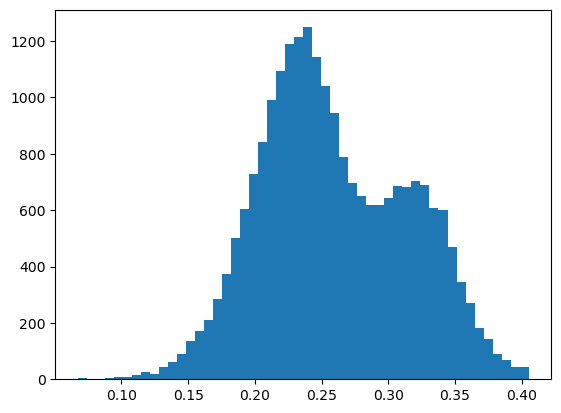

In [24]:
# histogram of distribution of state dependence estimated by dynamic random effects probit
import matplotlib.pyplot as plt
plt.hist(PE_lagy_RE, bins=50)
plt.show()

### Some remarks empirical example
1. LPM-FE gives good approximation of APE for Kids and log(hinc) in static models
2. Pooled Probit gives much higher estimates, indicating that Kids and log(hinc) are correlated with $c_i$
3. RE-probit with controls for means of Kids and log(hinc) give results similar to LPM-FE
3. In the dynamic model, pooled probit results in spurious state dependence (0.837) which is much higher than the results from the dynamic correlated random effects model (0.259)